# Compare the calculated radial matrix elements to pairinteraction and ARC

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate

from numerov.matrix_elements import radial_matrix_element
from numerov.rydberg import RydbergState
from numerov.units import ureg

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.WARNING)

In [2]:
# A few exemplary test cases, where pairinteraction and ARC do fail in various ways
dn, dl, dj, dm = (3, 1, 0, 0)
# dn, dl, dj, dm = (2, 0, 0, 0)
# dn, dl, dj, dm = (2, 2, 2, 0)
# dn, dl, dj, dm = (5, 1, 0, 0)
# dn, dl, dj, dm = (5, 2, 1, 0)
# qn_list: (n, l, j, mj)

qn1_list = np.array([(n1, n1 - 1, n1 - 0.5, n1 - 0.5) for n1 in range(20, 150)])
qn2_list = np.array([(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list])

In [3]:
matrixelements = {}

In [4]:
matrixelements["numerov"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = RydbergState("Rb", qn1[0], qn1[1], qn1[2])
    state_f = RydbergState("Rb", qn2[0], qn2[1], qn2[2])
    state_i.integrate()
    state_f.integrate()
    matrixelements["numerov"].append(radial_matrix_element(state_i, state_f, 1))

matrixelements["numerov"] = np.array(matrixelements["numerov"], dtype=float)
matrixelements["numerov"] *= ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

WARNING rydberg.py: xmin=173.1856 was not chosen good (sum_small_z=0.0012644004109388133), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=173.7124 was not chosen good (sum_small_z=0.0011279254803178282), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=193.7664 was not chosen good (sum_small_z=0.0011650690920261468), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=193.21 was not chosen good (sum_small_z=0.001023247793720388), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=215.5024 was not chosen good (sum_small_z=0.0010422427354885636), and the wavefunction is positive at the inner boundary, so we could not fix it.


In [5]:
matrixelements["hydrogen"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = RydbergState("H", qn1[0], qn1[1], qn1[2])
    state_i.create_model(add_spin_orbit=False)
    state_f = RydbergState("H", qn2[0], qn2[1], qn2[2])
    state_f.create_model(add_spin_orbit=False)
    state_i.integrate()
    state_f.integrate()
    matrixelements["hydrogen"].append(radial_matrix_element(state_i, state_f, 1))

matrixelements["hydrogen"] = np.array(matrixelements["hydrogen"], dtype=float)
matrixelements["hydrogen"] *= ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

WARNING rydberg.py: xmin=173.1856 was not chosen good (sum_small_z=0.0012856438869247415), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=173.7124 was not chosen good (sum_small_z=0.0011424566800356836), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=193.7664 was not chosen good (sum_small_z=0.0011832427348541026), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=193.21 was not chosen good (sum_small_z=0.0010361382391430591), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=215.5024 was not chosen good (sum_small_z=0.0010578587766983105), and the wavefunction is positive at the inner boundary, so we could not fix it.


In [6]:
from pairinteraction import pireal as pi

os.makedirs("./.pairinteraction_cache/", exist_ok=True)
cache = pi.MatrixElementCache("./.pairinteraction_cache/")

# Pairinteraction Numerov
cache.setMethod(pi.NUMEROV)
matrixelements["pairinteraction numerov"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
    state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])
    matrixelements["pairinteraction numerov"].append(cache.getRadial(state_f, state_i, 1))

matrixelements["pairinteraction numerov"] = np.array(matrixelements["pairinteraction numerov"], dtype=float)

# Pairinteraction Whittaker
cache.setMethod(pi.WHITTAKER)
matrixelements["pairinteraction whittaker"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
    state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])
    matrixelements["pairinteraction whittaker"].append(cache.getRadial(state_f, state_i, 1))

matrixelements["pairinteraction whittaker"] = np.array(matrixelements["pairinteraction whittaker"], dtype=float)

In [7]:
import arc

atom = arc.Rubidium87()

# ARC default
matrixelements["arc default"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    v = atom.getRadialMatrixElement(int(qn1[0]), int(qn1[1]), qn1[2], int(qn2[0]), int(qn2[1]), qn2[2])
    matrixelements["arc default"].append(v)

matrixelements["arc default"] = np.array(matrixelements["arc default"], dtype=float)
matrixelements["arc default"] *= ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

In [8]:
# ARC fixed
def fixed_getRadialMatrixElement(
    atom: arc.AlkaliAtom, n1: int, l1: int, j1: float, n2: int, l2: int, j2: float, s: float = 0.5
) -> float:
    step = 0.001
    r1, psi1_r1 = atom.radialWavefunction(
        l1,
        0.5,
        j1,
        atom.getEnergy(n1, l1, j1) / 27.211_386_245_988,  # Note the fixed Hartree energy
        atom.alphaC ** (1 / 3.0),
        2.0 * n1 * (n1 + 15.0),
        step,
    )
    r2, psi2_r2 = atom.radialWavefunction(
        l2,
        0.5,
        j2,
        atom.getEnergy(n2, l2, j2) / 27.211_386_245_988,  # Note the fixed Hartree energy
        atom.alphaC ** (1 / 3.0),
        2.0 * n2 * (n2 + 15.0),
        step,
    )
    upTo = min(len(r1), len(r2))
    dipoleElement = scipy.integrate.trapezoid(
        np.multiply(np.multiply(psi1_r1[0:upTo], psi2_r2[0:upTo]), r1[0:upTo]),
        x=r1[0:upTo],
    )
    return dipoleElement


matrixelements["arc fixed"] = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    v = fixed_getRadialMatrixElement(atom, int(qn1[0]), int(qn1[1]), qn1[2], int(qn2[0]), int(qn2[1]), qn2[2])
    matrixelements["arc fixed"].append(v)

matrixelements["arc fixed"] = np.array(matrixelements["arc fixed"], dtype=float)
matrixelements["arc fixed"] *= ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

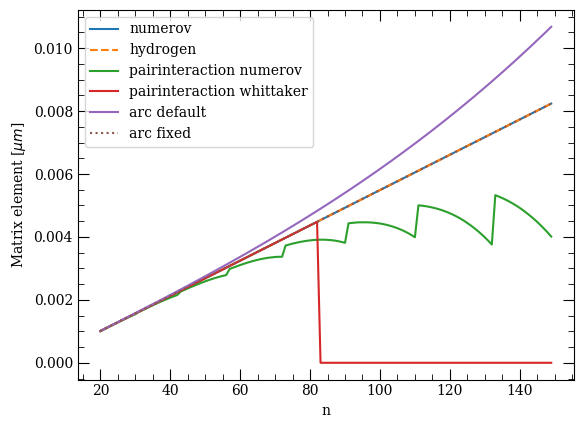

In [9]:
n_list = qn1_list[:, 0]
ls_dict = {"hydrogen": "--", "arc fixed": ":"}

fig, ax = plt.subplots()

for key, values in matrixelements.items():
    ls = ls_dict.get(key, "-")
    ax.plot(n_list, values, ls=ls, label=key)

ax.set_xlabel("n")
ax.set_ylabel(r"Matrix element [$\mu m$]")

ax.legend()
plt.show()